# Trabalho 3 - Equações Parabólicas e Hiperbólicas

## Métodos Numéricos para Equações Diferenciais

Este notebook contém a implementação e análise da equação unidimensional de advecção-difusão:

$$u_t + u_x = \frac{1}{Pe} u_{xx}$$

onde $Pe$ é o número de Péclet que caracteriza o balanço entre advecção e difusão.

### Objetivos:
1. Implementar e analisar a discretização por diferenças finitas da equação de advecção-difusão
2. Estudar o comportamento da solução para diferentes valores do número de Péclet:
   - Pe ≪ 1 (difusão dominante)
   - Pe = 1 (advecção e difusão equilibradas)
   - Pe ≫ 1 (advecção dominante)
3. Comparar diferentes esquemas numéricos:
   - Diferenças progressivas no tempo e centradas no espaço
   - Diferenças progressivas no tempo, centradas no espaço para termos difusivos e Upwind para termos advectivos

### Domínio do problema:
- Espaço: 0 ≤ x ≤ 15
- Tempo: 0 ≤ t ≤ 12
- Condição inicial: $u(x, 0) = \exp(-20(x-2)^2) + \exp(-(x-5)^2)$
- Condições de contorno periódicas

In [1]:
# Importações
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
# Parâmetros do Problema
L = 15.0  # Comprimento do domínio
T = 12.0  # Tempo total de simulação

# Condição inicial
def initial_condition(x):
    return np.exp(-20 * (x - 2)**2) + np.exp(-(x - 5)**2)


def solve_ftcs(Pe, Nx):
    dx = L / (Nx - 1)
    x = np.linspace(0, L, Nx)
    kappa = 1.0 / Pe

    cell_Pe = Pe * dx
    print(f"--- Iniciando FTCS com Pe = {Pe} ---")
    print(f"Número de Péclet da malha (Pe*dx): {cell_Pe:.2f}")

    dt = 0.4 * min(dx, dx**2 / (2 * kappa + 1e-9))
    Nt = int(T / dt)
    t = np.linspace(0, T, Nt)
    dt = T / (Nt - 1) 

    print(f"Nx = {Nx}, Nt = {Nt}, dx = {dx:.4f}, dt = {dt:.4f}")

    u = np.zeros((Nx, Nt))
    u[:, 0] = initial_condition(x)
    
    c_adv = dt / (2 * dx)
    c_diff = dt * kappa / dx**2
    
    for n in range(0, Nt - 1):
        for i in range(0, Nx):
            ip1 = (i + 1) % Nx
            im1 = (i - 1 + Nx) % Nx
            advection_term = c_adv * (u[ip1, n] - u[im1, n])  # Derivada primeira ordem 2 centrada
            diffusion_term = c_diff * (u[ip1, n] - 2*u[i, n] + u[im1, n]) # Derivada segunda ordem 2 centrada
            u[i, n+1] = u[i, n] - advection_term + diffusion_term   # N+1 temporal (explicito)
            
    return x, t, u


In [25]:
def plot_3d_side_by_side(results, titles, save_path="ftcs_results.png"):
    num_plots = len(results)
    fig = plt.figure(figsize=(6 * num_plots, 6))
    for idx, ((x, t, u), title) in enumerate(zip(results, titles)):
        t_step = max(1, len(t) // 100)
        x_step = max(1, len(x) // 100)
        t_plot = t[::t_step]
        x_plot = x[::x_step]
        u_plot = u[::x_step, ::t_step]
        T_grid, X_grid = np.meshgrid(t_plot, x_plot)
        ax = fig.add_subplot(1, num_plots, idx + 1, projection='3d')
        surf = ax.plot_surface(
            X_grid, T_grid, u_plot,
            cmap=cm.jet,
            rstride=1,
            cstride=1,
            linewidth=0,
            antialiased=True
        )
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        ax.set_zlabel('u')
        ax.set_title(title, pad=10)
        ax.view_init(elev=30, azim=-60)
        cb = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=12)
        cb.set_label('u')
    plt.tight_layout()
    plt.show()


def plot_comparison_3d(results, titles, save_path="upwind_comparison.png"):
    """Plota múltiplas soluções lado a lado em 3D"""
    num_plots = len(results)
    fig = plt.figure(figsize=(6 * num_plots, 6))
    
    for idx, ((x, t, u), title) in enumerate(zip(results, titles)):
        # Subamostragem para visualização mais rápida
        t_step = max(1, len(t) // 100)
        x_step = max(1, len(x) // 100)
        t_plot = t[::t_step]
        x_plot = x[::x_step]
        u_plot = u[::x_step, ::t_step]
        
        # Criação das malhas para plot
        T_grid, X_grid = np.meshgrid(t_plot, x_plot)
        
        # Subplot 3D
        ax = fig.add_subplot(1, num_plots, idx + 1, projection='3d')
        surf = ax.plot_surface(
            X_grid, T_grid, u_plot,
            cmap=cm.jet,
            rstride=1,
            cstride=1,
            linewidth=0,
            antialiased=True
        )
        
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        ax.set_zlabel('u')
        ax.set_title(title, pad=10)
        ax.view_init(elev=30, azim=-60)
        
        # Barra de cores
        cb = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=12)
        cb.set_label('u')
    
    plt.tight_layout()
    plt.show()

def plot_overlay_2d(result, title, base_time=0.0, num_times=6, time_step=0.1):
    """
    Plot 2D time evolution overlay for a single method
    Always includes t=0 plus additional time points
    
    Parameters:
    - result: tuple containing (x, t, u) arrays for one method
    - title: string for method name
    - base_time: starting time for plotting (in addition to t=0)
    - num_times: number of additional time points to plot (plus t=0)
    - time_step: time interval between plots
    """
    # Unpack the result
    x, t, u = result
    
    # Always include t=0, then add the requested time points
    times_to_plot = [0.0] + [base_time + i * time_step for i in range(num_times)]
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Colors for different time points
    colors = plt.cm.viridis(np.linspace(0, 1, len(times_to_plot)))
    
    for time_idx, t_target in enumerate(times_to_plot):
        # Find closest time index
        t_idx = np.argmin(np.abs(t - t_target))
        actual_time = t[t_idx]
        
        # Plot the solution at this time
        color = colors[time_idx]
        label = f't = {actual_time:.1f}'
        plt.plot(x, u[:, t_idx], color=color, linewidth=2, label=label)
    
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title(f'{title}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

--- Iniciando FTCS com Pe = 10 ---
Número de Péclet da malha (Pe*dx): 1.00
Nx = 151, Nt = 600, dx = 0.1000, dt = 0.0200
--- Iniciando FTCS com Pe = 1 ---
Número de Péclet da malha (Pe*dx): 0.10
Nx = 151, Nt = 6000, dx = 0.1000, dt = 0.0020
--- Iniciando FTCS com Pe = 0.5 ---
Número de Péclet da malha (Pe*dx): 0.05
Nx = 151, Nt = 12000, dx = 0.1000, dt = 0.0010


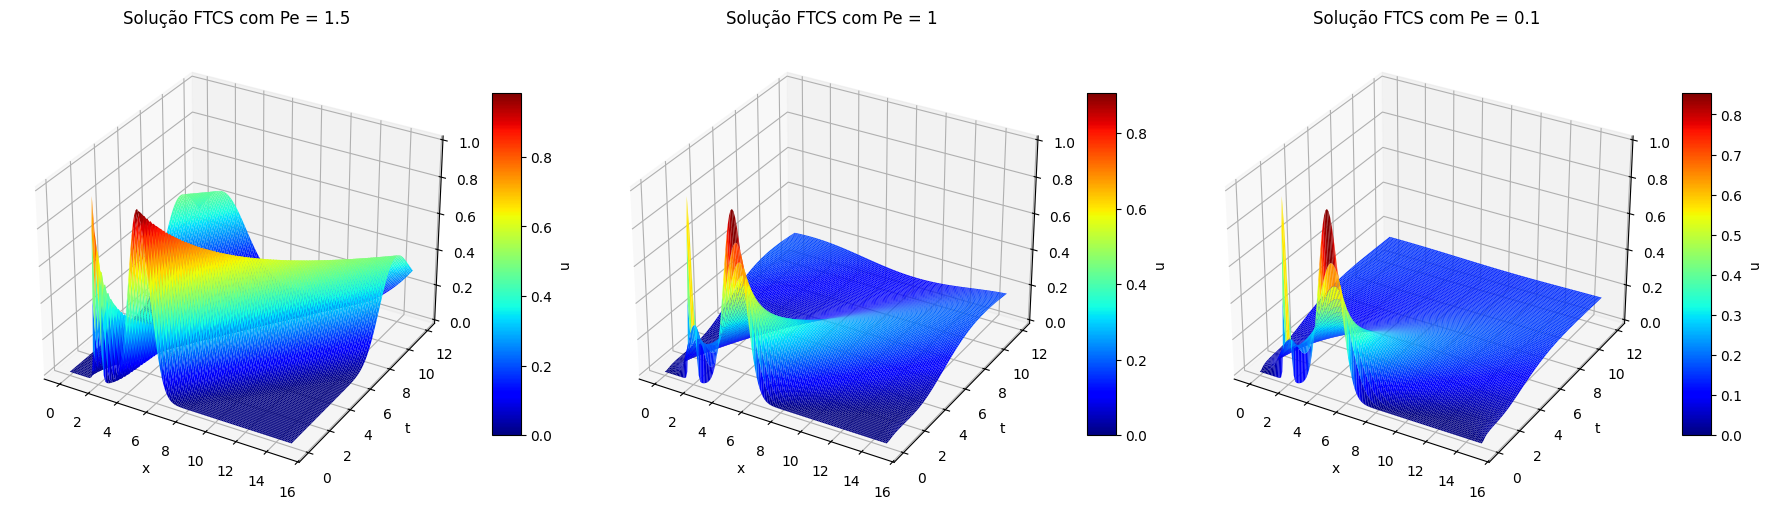

In [4]:
# Parâmetros e execuções
cases = [
    (10, 151),
    (1,   151),
    (0.5,  151)
]
titles = [
    'Solução FTCS com Pe = 1.5',
    'Solução FTCS com Pe = 1',
    'Solução FTCS com Pe = 0.1'
]
ftcs_results = [solve_ftcs(Pe, Nx) for Pe, Nx in cases]
plot_3d_side_by_side(ftcs_results, titles, save_path="ftcs_side_by_side.png")


 Note que como as condicoes de contorno sao periódicas, o domínio age como um cilindro, portanto, com a difusao grande a onda de calor se propaga atravez do lado direito do dominio e comeca a esquentar o lado esquerdo.

In [5]:
def solve_upwind(Pe, Nx):
    """
    Resolve a equação de advecção-difusão usando esquema Upwind para advecção
    e diferenças centradas para difusão.
    
    Parâmetros:
    - Pe: Número de Péclet
    - Nx: Número de pontos na malha espacial
    
    Retorna:
    - x: malha espacial
    - t: malha temporal
    - u: solução numérica
    """
    
    # Malha espacial
    dx = L / (Nx - 1)
    x = np.linspace(0, L, Nx)
    kappa = 1.0 / Pe  # Coeficiente de difusão
    
    # Número de Péclet da malha
    cell_Pe = Pe * dx
    print(f"--- Iniciando Upwind com Pe = {Pe} ---")
    print(f"Número de Péclet da malha (Pe*dx): {cell_Pe:.2f}")
    
    # Passo temporal baseado em critérios de estabilidade
    # Para Upwind: CFL ≤ 1 e critério de difusão
    dt_cfl = dx  # Critério CFL para Upwind (velocidade = 1)
    dt_diff = dx**2 / (2 * kappa + 1e-9)  # Critério de difusão
    dt = 0.4 * min(dt_cfl, dt_diff)
    
    Nt = int(T / dt) + 1
    t = np.linspace(0, T, Nt)
    dt = T / (Nt - 1)  # Reajuste para tempo exato
    
    print(f"Nx = {Nx}, Nt = {Nt}, dx = {dx:.4f}, dt = {dt:.4f}")
    print(f"CFL = {dt/dx:.3f}, Número de difusão = {dt*kappa/dx**2:.3f}")
    
    # Inicialização da matriz solução
    u = np.zeros((Nx, Nt))
    u[:, 0] = initial_condition(x)
    
    # Coeficientes do esquema
    c_adv = dt / dx       # Para termo advectivo (Upwind)
    c_diff = dt * kappa / dx**2  # Para termo difusivo (centradas)
    
    # Loop temporal
    for n in range(0, Nt - 1):
        for i in range(0, Nx):
            # Índices com condições periódicas
            ip1 = (i + 1) % Nx  # i+1 (próximo)
            im1 = (i - 1 + Nx) % Nx  # i-1 (anterior)
            
            # Termo advectivo usando Upwind (primeira ordem)
            # Como a velocidade é +1 (positiva), usamos diferenças para trás
            advection_term = c_adv * (u[i, n] - u[im1, n])
            
            # Termo difusivo usando diferenças centradas (segunda ordem)
            diffusion_term = c_diff * (u[ip1, n] - 2*u[i, n] + u[im1, n])
            
            # Atualização temporal (Euler explícito)
            u[i, n+1] = u[i, n] - advection_term + diffusion_term
    
    return x, t, u




ANÁLISE COMPARATIVA: ESQUEMA UPWIND vs FTCS

*** SIMULAÇÕES COM ESQUEMA UPWIND ***
--- Iniciando Upwind com Pe = 10 ---
Número de Péclet da malha (Pe*dx): 1.00
Nx = 151, Nt = 601, dx = 0.1000, dt = 0.0200
CFL = 0.200, Número de difusão = 0.200

--- Iniciando Upwind com Pe = 1 ---
Número de Péclet da malha (Pe*dx): 0.10
Nx = 151, Nt = 6001, dx = 0.1000, dt = 0.0020
CFL = 0.020, Número de difusão = 0.200

--- Iniciando Upwind com Pe = 0.1 ---
Número de Péclet da malha (Pe*dx): 0.01
Nx = 151, Nt = 60001, dx = 0.1000, dt = 0.0002
CFL = 0.002, Número de difusão = 0.200


*** SIMULAÇÕES COM ESQUEMA FTCS (para comparação) ***

*** VISUALIZAÇÃO DOS RESULTADOS ***
Plotando resultados com esquema Upwind...


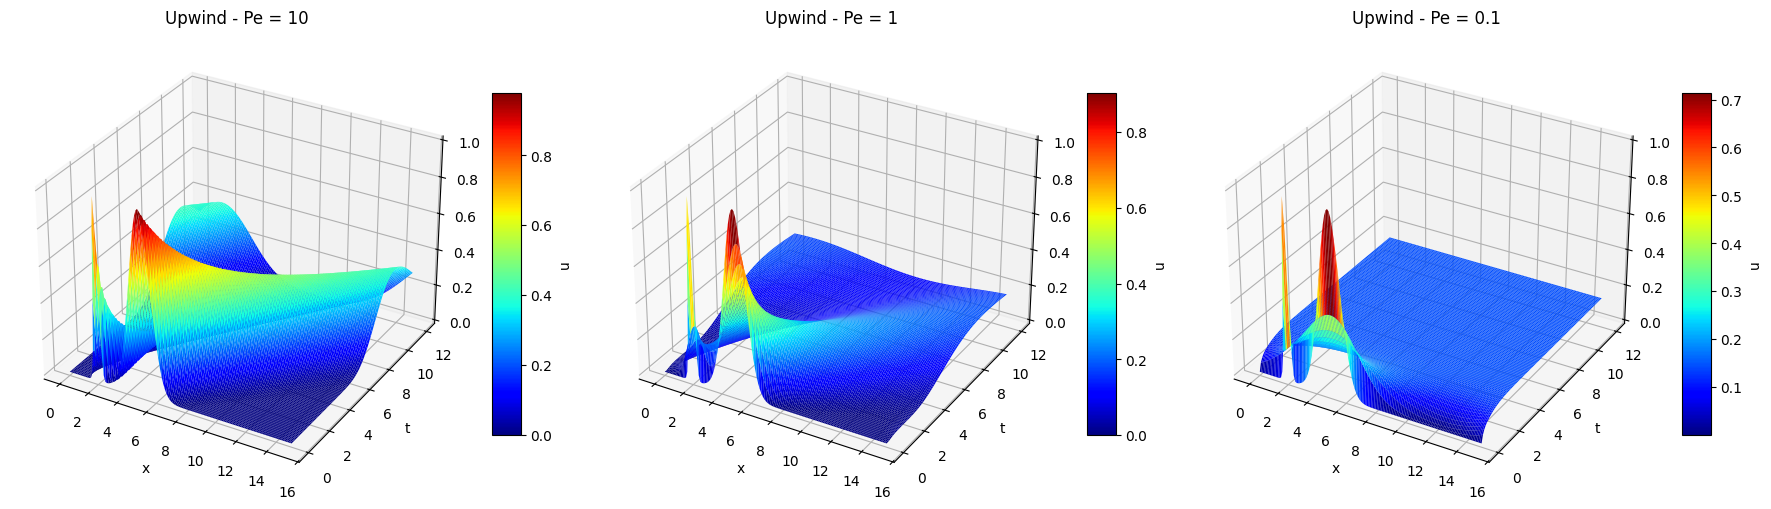

Plotando comparação Upwind vs FTCS para Pe = 10...


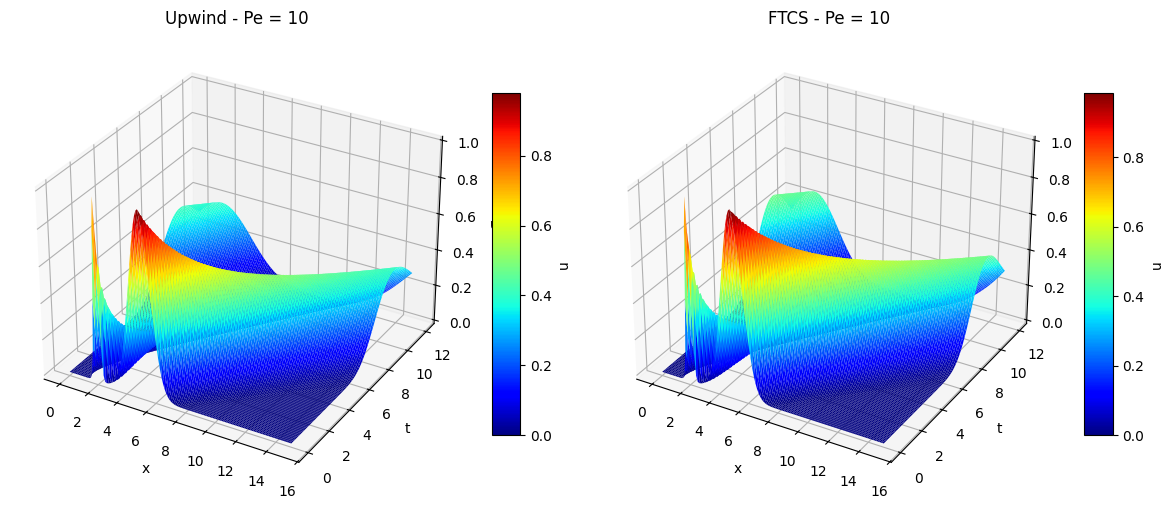

In [6]:

print("ANÁLISE COMPARATIVA: ESQUEMA UPWIND vs FTCS")

# Parâmetros para diferentes casos de Péclet
Pe_values = [10, 1, 0.1]  # Pe >> 1, Pe = 1, Pe << 1
Nx = 151  # Resolução espacial

# Executar simulações com Upwind
print("\n*** SIMULAÇÕES COM ESQUEMA UPWIND ***")
upwind_results = []

for Pe in Pe_values:
    result = solve_upwind(Pe, Nx)
    upwind_results.append(result)
    print()

# Executar simulações com FTCS para comparação
print("\n*** SIMULAÇÕES COM ESQUEMA FTCS (para comparação) ***")

# Títulos para os gráficos
upwind_titles = [f'Upwind - Pe = {Pe}' for Pe in Pe_values]
ftcs_titles = [f'FTCS - Pe = {Pe}' for Pe in Pe_values]

# Plotar resultados Upwind
print("\n*** VISUALIZAÇÃO DOS RESULTADOS ***")
print("Plotando resultados com esquema Upwind...")

plot_comparison_3d(upwind_results, upwind_titles, "upwind_results.png")

# Plotar comparação entre esquemas para Pe = 10 (advecção dominante)
print("Plotando comparação Upwind vs FTCS para Pe = 10...")

comparison_results = [upwind_results[0], ftcs_results[0]]
comparison_titles = ['Upwind - Pe = 10', 'FTCS - Pe = 10']

plot_comparison_3d(comparison_results, comparison_titles, "upwind_vs_ftcs_pe10.png")



Plotando evolução temporal em 2D...


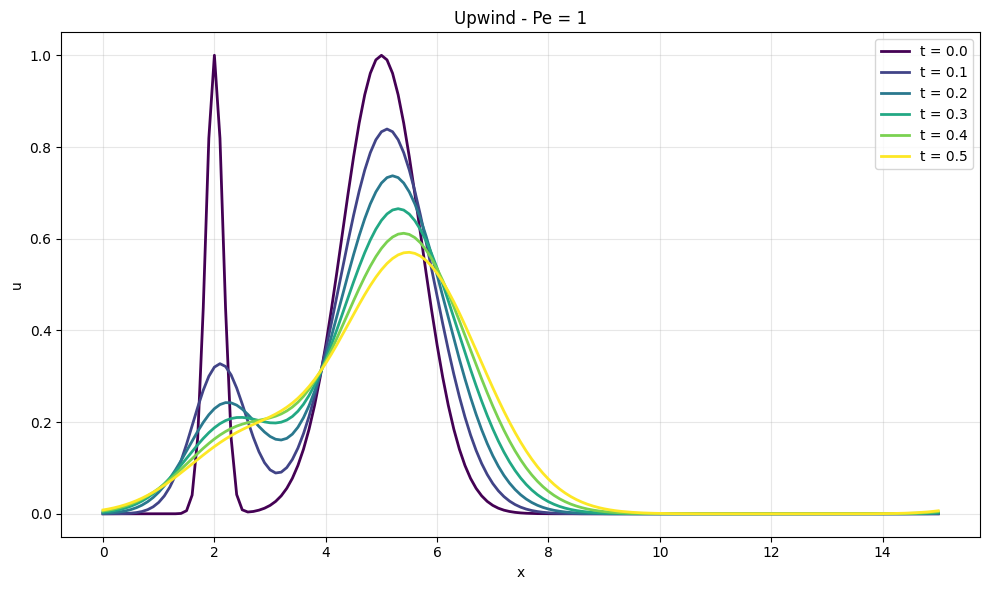

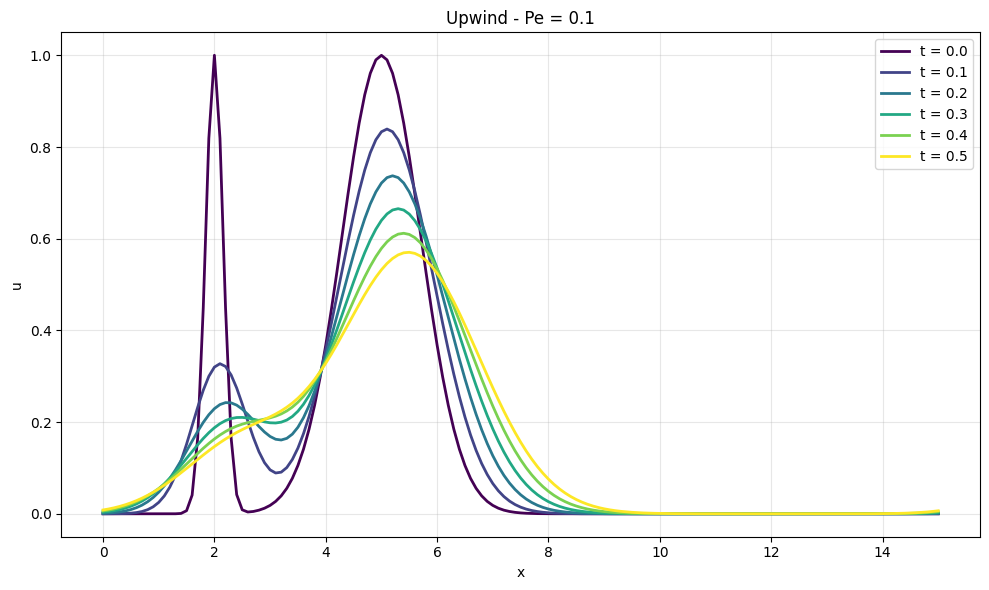

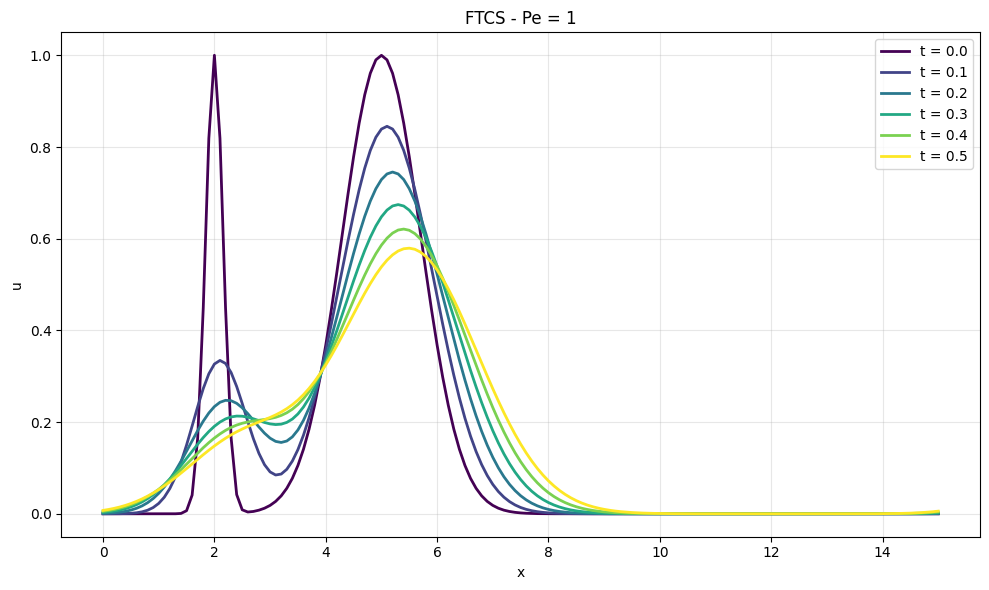

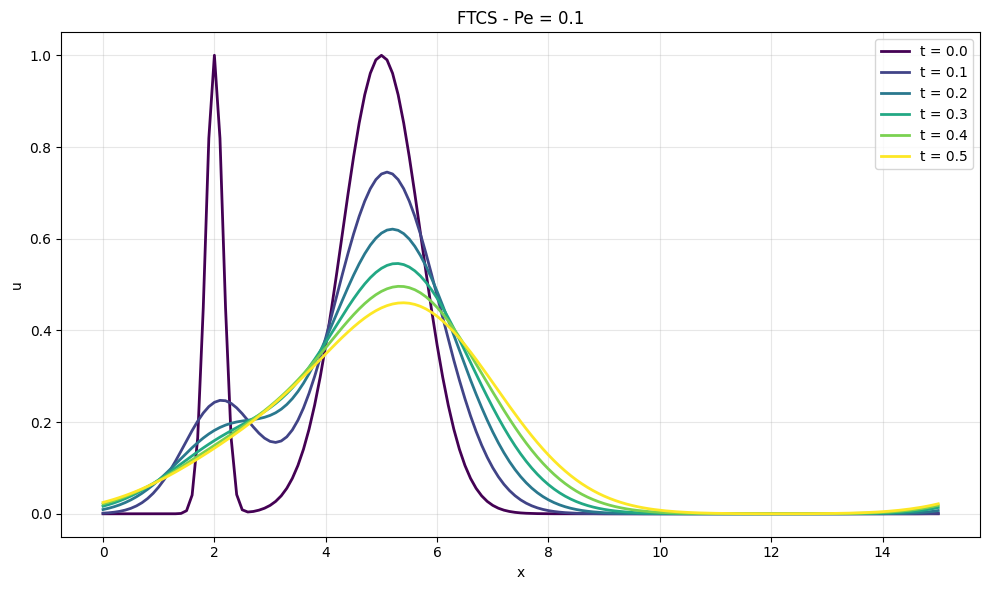

In [29]:

# Plotar comparação 2D em tempos específicos
print("Plotando evolução temporal em 2D...")

plot_overlay_2d(upwind_results[1], upwind_titles[1], base_time=0.1, num_times=5)
plot_overlay_2d(upwind_results[1], upwind_titles[2], base_time=0.1, num_times=5)


plot_overlay_2d(ftcs_results[1], ftcs_titles[1], base_time=0.1, num_times=5)
plot_overlay_2d(ftcs_results[2], ftcs_titles[2], base_time=0.1, num_times=5)



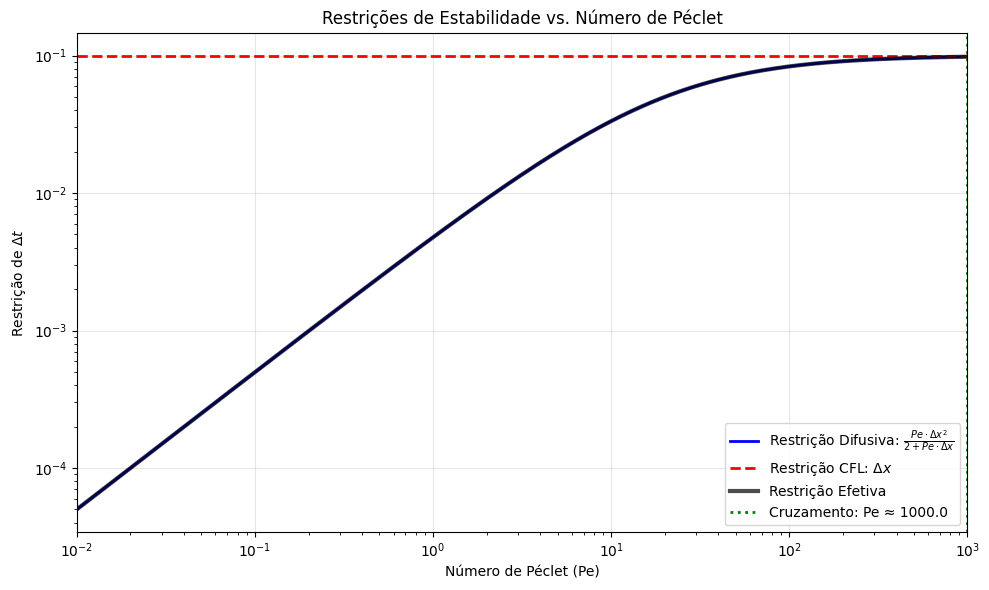

Ponto de cruzamento: Pe ≈ 1000.0
Pe crítico teórico: Pe = 2/Δx = 20.0


In [32]:
# Análise das Restrições de Estabilidade
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros
dx = 0.1
Pe_range = np.logspace(-2, 3, 1000)

# Restrições
restriction_diffusive = (Pe_range * dx**2) / (2 + Pe_range * dx)
restriction_cfl = np.full_like(Pe_range, dx)
effective_restriction = np.minimum(restriction_diffusive, restriction_cfl)

# Ponto de cruzamento
crossover_idx = np.argmin(np.abs(restriction_diffusive - restriction_cfl))
Pe_crossover = Pe_range[crossover_idx]

# Gráfico
plt.figure(figsize=(10, 6))
plt.loglog(Pe_range, restriction_diffusive, 'b-', linewidth=2, 
           label=r'Restrição Difusiva: $\frac{Pe \cdot \Delta x^2}{2 + Pe \cdot \Delta x}$')
plt.loglog(Pe_range, restriction_cfl, 'r--', linewidth=2, 
           label=r'Restrição CFL: $\Delta x$')
plt.loglog(Pe_range, effective_restriction, 'k-', linewidth=3, alpha=0.7,
           label='Restrição Efetiva')
plt.axvline(Pe_crossover, color='green', linestyle=':', linewidth=2, 
            label=f'Cruzamento: Pe ≈ {Pe_crossover:.1f}')

plt.xlabel('Número de Péclet (Pe)')
plt.ylabel(r'Restrição de $\Delta t$')
plt.title('Restrições de Estabilidade vs. Número de Péclet')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0.01, 1000)
plt.tight_layout()
plt.show()

print(f"Ponto de cruzamento: Pe ≈ {Pe_crossover:.1f}")
print(f"Pe crítico teórico: Pe = 2/Δx = {2/dx:.1f}")

## Análise das Restrições de Estabilidade

A equação de advecção-difusão possui duas restrições principais para estabilidade:

### 1. **Restrições Identificadas**

- **Restrição Difusiva**: $\Delta t < \frac{Pe \cdot \Delta x^2}{2 + Pe \cdot \Delta x}$
- **Restrição CFL (Advectiva)**: $\Delta t < \Delta x$

### 2. **Ponto de Cruzamento**

O cruzamento entre as duas restrições ocorre aproximadamente em:
$$Pe_{crit} = \frac{2}{\Delta x}$$

Para $\Delta x = 0.1$, temos $Pe_{crit} \approx 20$.

### 3. **Regimes de Operação**

**Regime Difusivo (Pe << Pe_crit)**
- A difusão domina o transporte
- Restrição difusiva é mais restritiva
- $\Delta t$ limitado pela estabilidade da difusão
- FTCS pode ser estável
- Métodos implícitos são vantajosos

**Regime Advectivo (Pe >> Pe_crit)**
- A advecção domina o transporte  
- Restrição CFL é mais restritiva
- $\Delta t$ limitado pela condição CFL
- FTCS torna-se instável
- Métodos upwind são necessários

### 4. **Implicações para Escolha do Método**

| Regime | Pe | Método Recomendado | Limitação Principal |
|--------|----|--------------------|-------------------|
| Difusivo | Pe < 20 | FTCS ou Implícito | Estabilidade difusiva |
| Transição | Pe ≈ 20 | Upwind | Ambas as restrições |
| Advectivo | Pe > 20 | Upwind | Condição CFL |

### 5. **Conclusão**

A análise mostra que a escolha do método numérico deve considerar o número de Péclet:
- Para problemas com baixo Pe, métodos centrados podem ser adequados
- Para alto Pe, métodos upwind são essenciais para evitar instabilidades
- O ponto de transição ($Pe \approx 2/\Delta x$) marca a mudança de regime físico dominante